In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(881)

# Define the model that generates pair simulations.
yuima = importr("yuima")
n_ou_sim_string = """
n_sim_ou = function(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length){

  set.seed(random_seed)

  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  ou_model = setModel(drift=drift, diffusion=diffusion, 
                        time.variable = "t",
                        state.var=c("X1","X2"), solve.variable=c("X1","X2"))

  newsamp = setSampling(Initial=T0, Terminal=T, n=length)

  n_sim_ou_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    ou_sim = simulate(ou_model, 
                      true.par=list(
                        mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                        sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22), 
                      xinit=xinit_vec[i], sampling=newsamp)
    original_data = ou_sim@data@original.data
    one_sim_ou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_ou) = c('series1', 'series2')
    n_sim_ou_data[, (2*i-1):(2*i)] = one_sim_ou
  }
  return(n_sim_ou_data)
}
"""

n_ou_sim = SignatureTranslatedAnonymousPackage(n_ou_sim_string, "n_ou_sim")
def n_ou_simulation(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length):
    """num_sim simulations of bivariate Ornstein-Uhlenbeck process,
    length = length of one series
    """
    n_ou_sim_data = pd.DataFrame(
        n_ou_sim.n_sim_ou(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22,
                              sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                              xinit_vec=xinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_ou_sim_data

def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef


def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    
    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2']
    
    return stats_data


def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)


    n_sim_log_price = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=mu11, mu12=params[0], 
        mu21=mu21, mu22=params[1],
        sigma11=params[2], sigma12=params[3], 
        sigma21=params[4], sigma22=params[5],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    
    sum_loss[0] = sum_loss[0]*50
    sum_loss[1] = sum_loss[1]*50    
    sum_loss[2] = sum_loss[2]*50
    sum_loss[3] = sum_loss[3]*50
    sum_loss[4] = sum_loss[4]*10
    sum_loss[5] = sum_loss[5]*10

    
    loss = np.sum(sum_loss)
    
    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats

mu11=0
mu21=0





initial0 = [1, 1, -1, -1, -1, -1]
begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

[1]  1  1 -1 -1 -1 -1

return_mean1        14003.601385
return_mean2        13403.985149
return_sd1          20873.563067
return_sd2          20071.067889
return_skew1         1604.537979
return_skew2         2182.533613
return_kurtosis1     1267.506655
return_kurtosis2     1799.352972
dtype: float64
75206.14870889537
----------
[1]  1  1 -1 -1 -1 -1

return_mean1        14269.283944
return_mean2        13669.667708
return_sd1          20699.812274
return_sd2          19923.928643
return_skew1         1660.696436
return_skew2         2229.947222
return_kurtosis1     1273.790909
return_kurtosis2     1805.943436
dtype: float64
75533.07057251447
----------
[1]  2  1 -1 -1 -1 -1

return_mean1        19173.892137
return_mean2        13604.997555
return_sd1          21882.565304
return_sd2          19935.624391
return_skew1         1641.054727
return_skew2         2182.003895
return_kurtosis1     1290.519205
return_kurtosis2     1820.741919
dtype: float64
81531.39913276241
----------
[1] -0.

return_mean1         2511.675619
return_mean2         2337.299975
return_sd1          20878.067605
return_sd2          20145.849173
return_skew1         1644.111458
return_skew2         2227.591749
return_kurtosis1     1278.909533
return_kurtosis2     1811.174106
dtype: float64
52834.67921668879
----------
[1]  0.03668599 -0.23606797 -1.00000000 -1.00000000 -1.00000000 -1.00000000

return_mean1         2468.461243
return_mean2         5435.632113
return_sd1          20479.555838
return_sd2          19722.787378
return_skew1         1680.875658
return_skew2         2257.219552
return_kurtosis1     1273.979137
return_kurtosis2     1805.175432
dtype: float64
55123.686351460594
----------
[1]  0.03668599  0.02730058 -1.00000000 -1.00000000 -1.00000000 -1.00000000

return_mean1         2643.752851
return_mean2         2477.566496
return_sd1          20610.619696
return_sd2          19861.651071
return_skew1         1683.732752
return_skew2         2208.708639
return_kurtosis1     1273.32608

return_mean1         2143.469757
return_mean2         2741.084106
return_sd1           9517.679396
return_sd2          19682.893026
return_skew1         1638.450388
return_skew2         2188.023976
return_kurtosis1     1273.177529
return_kurtosis2     1794.659318
dtype: float64
40979.437495925056
----------
[1]  0.03668599  0.08754779 -3.13735879 -1.00000000 -1.00000000 -1.00000000

return_mean1         2031.454496
return_mean2         2862.012700
return_sd1           9660.141467
return_sd2          19941.768569
return_skew1         1636.912100
return_skew2         2173.167461
return_kurtosis1     1271.891480
return_kurtosis2     1803.373682
dtype: float64
41380.72195566382
----------
[1]  0.03668599  0.08754779 -3.51783557 -1.00000000 -1.00000000 -1.00000000

return_mean1         1993.855955
return_mean2         2770.738732
return_sd1           9528.255480
return_sd2          19941.362715
return_skew1         1661.868392
return_skew2         2221.998684
return_kurtosis1     1278.07179

return_mean1         1796.813751
return_mean2         2587.704310
return_sd1           4369.254752
return_sd2          19743.926979
return_skew1         1649.564139
return_skew2         2195.618980
return_kurtosis1     1268.002730
return_kurtosis2     1805.441674
dtype: float64
35416.327316681294
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37595980 -1.00000000 -1.00000000

return_mean1         1830.648945
return_mean2         2765.646033
return_sd1           4361.252456
return_sd2          19854.308042
return_skew1         1663.230090
return_skew2         2194.262334
return_kurtosis1     1276.147147
return_kurtosis2     1801.616639
dtype: float64
35747.11168545189
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37871127 -1.00000000 -1.00000000

return_mean1         1821.615879
return_mean2         2815.956776
return_sd1           4316.920549
return_sd2          19982.633925
return_skew1         1667.033063
return_skew2         2244.293934
return_kurtosis1     1280.86855

return_mean1        1921.698307
return_mean2        2659.653619
return_sd1          4317.990412
return_sd2          9343.830453
return_skew1        1666.330851
return_skew2        2176.549248
return_kurtosis1    1278.575908
return_kurtosis2    1811.430827
dtype: float64
25176.059624970636
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37833750 -3.15805961 -1.00000000

return_mean1        1963.199346
return_mean2        2634.345582
return_sd1          4338.236779
return_sd2          9154.879838
return_skew1        1653.641121
return_skew2        2201.520386
return_kurtosis1    1275.977663
return_kurtosis2    1808.505373
dtype: float64
25030.306088561563
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37833750 -3.17050071 -1.00000000

return_mean1        1791.311489
return_mean2        2426.705437
return_sd1          4330.645557
return_sd2          9015.305727
return_skew1        1659.547331
return_skew2        2226.016234
return_kurtosis1    1273.669944
return_kurtosis2    

return_mean1        1890.579976
return_mean2        2414.572269
return_sd1          4370.841408
return_sd2          4869.681653
return_skew1        1675.365431
return_skew2        2214.627370
return_kurtosis1    1278.012957
return_kurtosis2    1809.807513
dtype: float64
20523.488577147138
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37833750 -3.17149360 -1.39051419

return_mean1        1831.927800
return_mean2        2363.694786
return_sd1          4323.958568
return_sd2          4973.686471
return_skew1        1662.751390
return_skew2        2208.771243
return_kurtosis1    1272.824484
return_kurtosis2    1804.732618
dtype: float64
20442.34735875078
----------
[1]  0.03668599  0.08754779 -3.48105240 -1.37833750 -3.17149360 -1.39071456

return_mean1        1912.266343
return_mean2        2409.716679
return_sd1          4331.992942
return_sd2          4999.009539
return_skew1        1630.391217
return_skew2        2203.559911
return_kurtosis1    1272.592484
return_kurtosis2    1

return_mean1        1699.493391
return_mean2        2312.946603
return_sd1          4371.354018
return_sd2          4947.583334
return_skew1        1657.178711
return_skew2        2189.512936
return_kurtosis1    1269.849749
return_kurtosis2    1802.862587
dtype: float64
20250.781328439127
----------
[1]  0.02898406  0.08754779 -3.48105240 -1.37833750 -3.17149360 -1.39087779

return_mean1        1758.562595
return_mean2        2377.707139
return_sd1          4336.177210
return_sd2          4900.954856
return_skew1        1680.238168
return_skew2        2207.681616
return_kurtosis1    1279.363561
return_kurtosis2    1812.196170
dtype: float64
20352.881313746184
----------
[1]  0.02909434  0.08754779 -3.48105240 -1.37833750 -3.17149360 -1.39087779

return_mean1        1777.243842
return_mean2        2345.762140
return_sd1          4340.093817
return_sd2          4933.337555
return_skew1        1680.239498
return_skew2        2213.504967
return_kurtosis1    1279.742024
return_kurtosis2    

return_mean1        1734.564441
return_mean2        1486.734868
return_sd1          4295.480931
return_sd2          5006.982310
return_skew1        1659.126709
return_skew2        2247.805532
return_kurtosis1    1269.107440
return_kurtosis2    1801.936176
dtype: float64
19501.738406557142
----------
[1]  0.02903335  0.02684136 -3.48105240 -1.37833750 -3.17149360 -1.39087779

return_mean1        1645.829375
return_mean2        1579.547047
return_sd1          4370.917795
return_sd2          4951.846260
return_skew1        1679.365536
return_skew2        2213.596273
return_kurtosis1    1273.177002
return_kurtosis2    1804.435021
dtype: float64
19518.714308770057
----------
[1]  0.02903335  0.01355051 -3.48105240 -1.37833750 -3.17149360 -1.39087779

return_mean1        1875.242800
return_mean2        1616.501790
return_sd1          4353.505866
return_sd2          4910.161440
return_skew1        1659.592873
return_skew2        2196.399404
return_kurtosis1    1270.134607
return_kurtosis2    

return_mean1        1747.673780
return_mean2        1578.377854
return_sd1          4272.385407
return_sd2          4923.979396
return_skew1        1648.949129
return_skew2        2233.183203
return_kurtosis1    1271.555780
return_kurtosis2    1803.185698
dtype: float64
19479.290247624114
----------
[1]  0.02903335  0.01001134 -4.34214759 -1.37833750 -3.17149360 -1.39087779

return_mean1        1768.624066
return_mean2        1580.368770
return_sd1          4333.043753
return_sd2          4934.752087
return_skew1        1701.580074
return_skew2        2236.621738
return_kurtosis1    1272.154484
return_kurtosis2    1805.619558
dtype: float64
19632.76452947831
----------
[1]  0.02903335  0.01001134 -4.29726290 -1.37833750 -3.17149360 -1.39087779

return_mean1        1796.752053
return_mean2        1540.460125
return_sd1          4270.617891
return_sd2          4910.183792
return_skew1        1666.966811
return_skew2        2204.296677
return_kurtosis1    1272.100338
return_kurtosis2    1

return_mean1        2003.445436
return_mean2        1658.770618
return_sd1          4457.123267
return_sd2          5022.541129
return_skew1        1626.756717
return_skew2        2179.599931
return_kurtosis1    1273.475248
return_kurtosis2    1805.549877
dtype: float64
20027.262221736753
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.35240392 -3.17149360 -1.39087779

return_mean1        1789.038878
return_mean2        1477.763992
return_sd1          4402.042261
return_sd2          4969.801690
return_skew1        1653.228924
return_skew2        2218.236163
return_kurtosis1    1271.398383
return_kurtosis2    1802.561880
dtype: float64
19584.072170261876
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34554837 -3.17149360 -1.39087779

return_mean1        1822.794770
return_mean2        1474.013163
return_sd1          4397.162799
return_sd2          4933.298218
return_skew1        1661.680396
return_skew2        2201.056365
return_kurtosis1    1274.351271
return_kurtosis2    

return_mean1        1816.822649
return_mean2        1523.962452
return_sd1          4381.450038
return_sd2          5009.525857
return_skew1        1677.394321
return_skew2        2221.780333
return_kurtosis1    1274.337559
return_kurtosis2    1804.652234
dtype: float64
19709.925442663043
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34841067 -4.40756157 -1.39087779

return_mean1        1761.719234
return_mean2        1557.013171
return_sd1          4451.832257
return_sd2          5021.650922
return_skew1        1652.376561
return_skew2        2236.183204
return_kurtosis1    1270.118359
return_kurtosis2    1802.121767
dtype: float64
19753.015473794025
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34841067 -4.14494044 -1.39087779

return_mean1        1817.038836
return_mean2        1541.589788
return_sd1          4293.101608
return_sd2          4983.697181
return_skew1        1676.630800
return_skew2        2212.356036
return_kurtosis1    1271.163330
return_kurtosis2    

return_mean1        1806.640934
return_mean2        1619.785518
return_sd1          4363.020172
return_sd2          4886.094488
return_skew1        1636.106805
return_skew2        2211.868450
return_kurtosis1    1274.356707
return_kurtosis2    1809.071298
dtype: float64
19606.944372596932
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34841067 -4.14288400 -1.39490382

return_mean1        1747.725218
return_mean2        1516.883348
return_sd1          4527.380583
return_sd2          4866.836974
return_skew1        1628.512890
return_skew2        2192.213253
return_kurtosis1    1278.237342
return_kurtosis2    1809.802952
dtype: float64
19567.592559680892
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34841067 -4.14288400 -1.38019511

return_mean1        1795.596039
return_mean2        1617.993504
return_sd1          4423.417997
return_sd2          5027.697894
return_skew1        1638.666852
return_skew2        2176.543231
return_kurtosis1    1270.066258
return_kurtosis2    

return_mean1        1949.084489
return_mean2        1682.589858
return_sd1          4437.664896
return_sd2          4958.095859
return_skew1        1696.541158
return_skew2        2205.499954
return_kurtosis1    1260.993545
return_kurtosis2    1793.345374
dtype: float64
19983.81513284924
----------
[1]  0.02903335  0.01001134 -4.29734453 -1.34841067 -4.14288400 -1.38739235

return_mean1        1777.827705
return_mean2        1525.343822
return_sd1          4360.384542
return_sd2          4910.182463
return_skew1        1596.206173
return_skew2        2202.559318
return_kurtosis1    1259.119651
return_kurtosis2    1790.817441
dtype: float64
19422.441116115013
----------
[1]  0.02138071 -0.06752510 -5.11363666 -1.31848383 -5.11427440 -1.38390760

return_mean1        1665.956679
return_mean2        1760.691972
return_sd1          4442.555632
return_sd2          4978.454969
return_skew1        1670.587510
return_skew2        2226.769392
return_kurtosis1    1271.065919
return_kurtosis2    1

return_mean1        1635.467159
return_mean2        1523.254370
return_sd1          4464.230577
return_sd2          4985.810156
return_skew1        1660.274636
return_skew2        2198.708522
return_kurtosis1    1269.456231
return_kurtosis2    1801.642784
dtype: float64
19538.844435017927
----------
[1]  0.02611092 -0.01959867 -4.60907432 -1.33698205 -4.51384350 -1.38606179

return_mean1        1789.679057
return_mean2        1470.047220
return_sd1          4489.151269
return_sd2          4923.730513
return_skew1        1645.133688
return_skew2        2205.782002
return_kurtosis1    1280.201953
return_kurtosis2    1809.377102
dtype: float64
19613.10280289221
----------
[1]  0.02610975 -0.01961055 -4.60919941 -1.33697747 -4.51399236 -1.38606126

return_mean1        1784.589215
return_mean2        1503.270465
return_sd1          4398.199755
return_sd2          4966.321073
return_skew1        1651.161377
return_skew2        2208.964656
return_kurtosis1    1268.882682
return_kurtosis2    1

return_mean1        1690.619921
return_mean2        1483.456900
return_sd1          4443.492799
return_sd2          5021.153115
return_skew1        1691.033693
return_skew2        2203.722408
return_kurtosis1    1270.265168
return_kurtosis2    1801.435775
dtype: float64
19605.179779810518
----------
[1]  0.02535746 -0.01960494 -4.60914037 -1.33697963 -4.51392210 -1.38606151

return_mean1        1754.806536
return_mean2        1498.584295
return_sd1          4518.651288
return_sd2          4900.795917
return_skew1        1668.029345
return_skew2        2207.728591
return_kurtosis1    1275.573039
return_kurtosis2    1808.016103
dtype: float64
19632.185114982676
----------
[1]  0.02539719 -0.01960494 -4.60914037 -1.33697963 -4.51392210 -1.38606151

return_mean1        1743.755350
return_mean2        1544.598663
return_sd1          4453.979478
return_sd2          5000.255135
return_skew1        1672.873042
return_skew2        2177.231900
return_kurtosis1    1276.761185
return_kurtosis2    

return_mean1        1743.704331
return_mean2        1552.118724
return_sd1          4411.437260
return_sd2          4949.101085
return_skew1        1657.768163
return_skew2        2249.408022
return_kurtosis1    1267.336298
return_kurtosis2    1797.223945
dtype: float64
19628.097828477228
----------
[1]  0.02538116 -0.01960494 -4.60914037 -1.33697963 -4.51392210 -1.35971891

return_mean1        1772.486895
return_mean2        1579.221339
return_sd1          4356.306416
return_sd2          4919.540830
return_skew1        1657.036766
return_skew2        2198.741345
return_kurtosis1    1279.176347
return_kurtosis2    1811.643231
dtype: float64
19574.153168652454
----------
[1]  0.02538116 -0.01960494 -4.60914037 -1.33697963 -4.51392210 -1.37387083

return_mean1        1763.292187
return_mean2        1484.984787
return_sd1          4272.317449
return_sd2          4885.805252
return_skew1        1650.067351
return_skew2        2188.719106
return_kurtosis1    1280.550300
return_kurtosis2    

return_mean1        1687.972312
return_mean2        1461.224823
return_sd1          4450.776864
return_sd2          4845.133059
return_skew1        1681.462228
return_skew2        2222.132914
return_kurtosis1    1271.521858
return_kurtosis2    1804.423105
dtype: float64
19424.647161809153
----------
[1]  0.02538116 -0.01960494 -5.22613247 -1.33697963 -4.51392210 -1.37387083

return_mean1        1669.981131
return_mean2        1455.569938
return_sd1          4423.833802
return_sd2          4912.554124
return_skew1        1642.617856
return_skew2        2223.438298
return_kurtosis1    1275.476007
return_kurtosis2    1808.149733
dtype: float64
19411.620888150774
----------
[1]  0.02538116 -0.01960494 -5.22677638 -1.33697963 -4.51392210 -1.37387083

return_mean1        1810.676423
return_mean2        1568.057631
return_sd1          4385.787453
return_sd2          4902.365870
return_skew1        1655.383431
return_skew2        2193.156039
return_kurtosis1    1274.850648
return_kurtosis2    

return_mean1        1920.224367
return_mean2        1554.258844
return_sd1          4288.412852
return_sd2          4991.074100
return_skew1        1662.568751
return_skew2        2177.384521
return_kurtosis1    1268.202391
return_kurtosis2    1801.185156
dtype: float64
19663.31098215757
----------
[1]  0.02538116 -0.01960494 -5.22717434 -1.36182340 -4.51392210 -1.37387083

return_mean1        1701.222298
return_mean2        1422.940949
return_sd1          4308.927666
return_sd2          4898.847408
return_skew1        1683.799384
return_skew2        2173.945055
return_kurtosis1    1273.293613
return_kurtosis2    1805.170488
dtype: float64
19268.14686243821
----------
[1]  0.02538116 -0.01960494 -5.22717434 -1.36181435 -4.51392210 -1.37387083

return_mean1        1774.729166
return_mean2        1568.116780
return_sd1          4259.135005
return_sd2          4942.795636
return_skew1        1638.526548
return_skew2        2196.879173
return_kurtosis1    1284.758886
return_kurtosis2    18

return_mean1        1768.225987
return_mean2        1463.354115
return_sd1          4355.413965
return_sd2          4934.625319
return_skew1        1632.981501
return_skew2        2158.188146
return_kurtosis1    1270.643592
return_kurtosis2    1801.565289
dtype: float64
19384.997914660053
----------
[1]  0.02245812 -0.04922123 -5.53897018 -1.35037772 -5.23095506 -1.37253964

return_mean1        1705.400790
return_mean2        1483.596135
return_sd1          4336.671968
return_sd2          4946.737434
return_skew1        1625.438963
return_skew2        2189.355330
return_kurtosis1    1269.210857
return_kurtosis2    1801.495847
dtype: float64
19357.907323293417
----------
[1]  0.01772853 -0.09714139 -6.04346645 -1.33188192 -5.83130733 -1.37038573

return_mean1        1682.017502
return_mean2        2187.942711
return_sd1          4386.754741
return_sd2          5010.870515
return_skew1        1672.036768
return_skew2        2245.634339
return_kurtosis1    1276.829202
return_kurtosis2    

return_mean1        1685.446409
return_mean2        1496.222306
return_sd1          4409.442251
return_sd2          4975.121907
return_skew1        1664.745822
return_skew2        2208.890970
return_kurtosis1    1284.932656
return_kurtosis2    1815.204534
dtype: float64
19540.006853568884
----------
[1]  0.02461402 -0.02737760 -5.30900370 -1.35880873 -4.95729417 -1.37352146

return_mean1        1733.715008
return_mean2        1568.409286
return_sd1          4335.505386
return_sd2          5008.129303
return_skew1        1663.427989
return_skew2        2212.314182
return_kurtosis1    1267.097330
return_kurtosis2    1799.666092
dtype: float64
19588.264575857393
----------
[1]  0.02461434 -0.02737443 -5.30897035 -1.35880995 -4.95725448 -1.37352161

return_mean1        1823.053939
return_mean2        1572.374259
return_sd1          4439.520351
return_sd2          5048.482179
return_skew1        1676.086745
return_skew2        2218.343725
return_kurtosis1    1272.355033
return_kurtosis2    

return_mean1        1742.907993
return_mean2        1439.070279
return_sd1          4438.921668
return_sd2          4956.300384
return_skew1        1642.702545
return_skew2        2198.664759
return_kurtosis1    1283.720625
return_kurtosis2    1815.596994
dtype: float64
19517.885247750542
----------
[1]  0.02462573 -0.02737564 -5.30898309 -1.35880949 -4.95726964 -1.37352155

return_mean1        1684.361064
return_mean2        1436.898196
return_sd1          4327.502796
return_sd2          4853.493080
return_skew1        1645.411183
return_skew2        2190.007525
return_kurtosis1    1278.608830
return_kurtosis2    1811.199525
dtype: float64
19227.48219990072
----------
[1]  0.02463285 -0.02737564 -5.30898309 -1.35880949 -4.95726964 -1.37352155

return_mean1        1684.128159
return_mean2        1447.419788
return_sd1          4331.349006
return_sd2          5036.217690
return_skew1        1620.294922
return_skew2        2199.153792
return_kurtosis1    1269.851171
return_kurtosis2    1

return_mean1         1606.683145
return_mean2         2764.550725
return_sd1           4447.042481
return_sd2          32706.263208
return_skew1         1685.219097
return_skew2         2205.207284
return_kurtosis1     1281.797943
return_kurtosis2     1814.122491
dtype: float64
48510.88637398647
----------
[1]  0.02462573 -0.02737564 -5.30898309 -1.35880949 -4.95726964 -2.99155555

return_mean1         1739.695258
return_mean2         1123.563675
return_sd1           4375.271557
return_sd2          17206.115096
return_skew1         1647.555554
return_skew2         2171.660152
return_kurtosis1     1275.967039
return_kurtosis2     1810.072435
dtype: float64
31349.9007668805
----------
[1]  0.02462573 -0.02737564 -5.30898309 -1.35880949 -4.95726964 -1.37352155

return_mean1        1671.876360
return_mean2        1455.869956
return_sd1          4358.718180
return_sd2          4959.289689
return_skew1        1647.390280
return_skew2        2202.991674
return_kurtosis1    1279.219204
return_

return_mean1        1778.909346
return_mean2        1583.030448
return_sd1          4334.839867
return_sd2          5087.843252
return_skew1        1671.692068
return_skew2        2217.954976
return_kurtosis1    1275.209260
return_kurtosis2    1809.235993
dtype: float64
19758.715211274262
----------
[1]  0.02462573 -0.02737564 -4.30898309 -1.35880949 -4.95726964 -1.37966128

return_mean1        1696.516142
return_mean2        1509.154558
return_sd1          4321.429444
return_sd2          4954.647815
return_skew1        1603.702177
return_skew2        2222.608379
return_kurtosis1    1266.507758
return_kurtosis2    1798.078786
dtype: float64
19372.645059657523
----------
[1]  0.02462573 -0.02737564 -2.69094909 -1.35880949 -4.95726964 -1.37966128

return_mean1        1743.005905
return_mean2        1549.089917
return_sd1          4498.842336
return_sd2          4945.167686
return_skew1        1640.562545
return_skew2        2196.610997
return_kurtosis1    1266.791234
return_kurtosis2    

return_mean1        1802.225162
return_mean2        1529.991820
return_sd1          4403.235523
return_sd2          4858.947867
return_skew1        1658.283071
return_skew2        2222.271737
return_kurtosis1    1259.601028
return_kurtosis2    1792.535429
dtype: float64
19527.09163713381
----------
[1]  0.02462573 -0.02737564 -4.78415855 -1.35880949 -4.95726964 -1.37966128

return_mean1        1681.909048
return_mean2        1521.463135
return_sd1          4297.364652
return_sd2          4976.914559
return_skew1        1631.495333
return_skew2        2187.031913
return_kurtosis1    1272.662798
return_kurtosis2    1806.340928
dtype: float64
19375.18236678023
----------
[1]  0.02462573 -0.02737564 -4.78427713 -1.35880949 -4.95726964 -1.37966128

return_mean1        1829.788121
return_mean2        1507.808369
return_sd1          4375.259051
return_sd2          4950.905055
return_skew1        1665.292358
return_skew2        2183.892798
return_kurtosis1    1271.213010
return_kurtosis2    18

return_mean1        1636.382900
return_mean2        1468.270117
return_sd1          4281.065393
return_sd2          4926.718787
return_skew1        1642.096556
return_skew2        2198.901831
return_kurtosis1    1267.990923
return_kurtosis2    1799.730546
dtype: float64
19221.157052940587
----------
[1]  0.02462573 -0.02737564 -4.78422465 -1.41158089 -4.95726964 -1.37966128

return_mean1        1664.957481
return_mean2        1456.741872
return_sd1          4291.235087
return_sd2          4892.112841
return_skew1        1598.630292
return_skew2        2167.160159
return_kurtosis1    1272.459385
return_kurtosis2    1805.019669
dtype: float64
19148.316784315357
----------
[1]  0.02462573 -0.02737564 -4.78422465 -1.41155441 -4.95726964 -1.37966128

return_mean1        1654.822690
return_mean2        1524.877943
return_sd1          4319.355836
return_sd2          4987.453011
return_skew1        1660.662148
return_skew2        2205.063733
return_kurtosis1    1270.527328
return_kurtosis2    

return_mean1        1664.493534
return_mean2        1472.223094
return_sd1          4387.769434
return_sd2          4967.029703
return_skew1        1664.107865
return_skew2        2204.951431
return_kurtosis1    1269.563113
return_kurtosis2    1801.880312
dtype: float64
19432.018485924942
----------
[1]  0.02462573 -0.02737564 -4.78422465 -1.41158089 -4.95890899 -1.37966128

return_mean1        1730.368660
return_mean2        1502.172272
return_sd1          4358.796082
return_sd2          4969.034906
return_skew1        1646.983442
return_skew2        2221.541122
return_kurtosis1    1276.979419
return_kurtosis2    1807.628294
dtype: float64
19513.504196752536
----------
[1]  0.02462573 -0.02737564 -4.78422465 -1.41158089 -4.95936209 -1.37966128

return_mean1        1709.493473
return_mean2        1592.836609
return_sd1          4410.898192
return_sd2          4952.110284
return_skew1        1657.455557
return_skew2        2249.919130
return_kurtosis1    1277.603942
return_kurtosis2    

return_mean1        1729.062569
return_mean2        1464.547662
return_sd1          4337.694694
return_sd2          4916.488547
return_skew1        1644.805983
return_skew2        2204.887146
return_kurtosis1    1273.733697
return_kurtosis2    1805.757703
dtype: float64
19376.977999878272
----------
[1]  0.0274010515  0.0007438691 -4.4881866545 -1.4224342079 -4.6069028000
[6] -1.3809251890

return_mean1        1711.726272
return_mean2        1461.986460
return_sd1          4391.877514
return_sd2          4907.140677
return_skew1        1692.620712
return_skew2        2237.637102
return_kurtosis1    1275.478133
return_kurtosis2    1807.766373
dtype: float64
19486.233241730337
----------
[1]  0.028238817  0.009232102 -4.398823803 -1.425710422 -4.500560704
[6] -1.381306717

return_mean1        1828.793780
return_mean2        1547.210662
return_sd1          4414.760680
return_sd2          5013.811993
return_skew1        1683.637628
return_skew2        2193.644701
return_kurtosis1    1279.5

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

[1]  0.027557857  0.002332622 -4.471460498 -1.423047421 -4.586998617
[6] -1.380996600



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  

parameter F test:         F=4.7384  , p=0.0096  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8792  , p=0.4165  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.7945  , p=0.4077  , df=2
likelihood ratio test: chi2=1.7880  , p=0.4090  , df=2
parameter F test:         F=0.8792  , p=0.4165  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1454  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2570  , p=0.0023  , df=1
likelihood ratio test: chi2=9.0891  , p=0.0026  , df=1
parameter F test:         F=9.1454  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0094  , p=0.9229  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0095  , p=0.9223  , df=1
likelihood ratio test: chi2=0.0095  , p=0.9223  , df=1
parameter F test:         F=0.0094  , p=0.9229  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7643  , p=0.0673  , df=4
likelihood ratio test: chi2=8.6117  , p=0.0716  , df=4
parameter F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.6261  , p=0.0712  , df=4
likelihood ratio test: chi2=8.4783  , p=0.0755  , df=4
parameter F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7249  , p=0.0942  , df=2
likelihood ratio test: chi2=4.6805  , p=0.0963  , df=2
parameter F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3174  , p=0.7283  

likelihood ratio test: chi2=0.1028  , p=0.7485  , df=1
parameter F test:         F=0.1016  , p=0.7502  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2218  , p=0.2701  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2367  , p=0.2661  , df=1
likelihood ratio test: chi2=1.2337  , p=0.2667  , df=1
parameter F test:         F=1.2218  , p=0.2701  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4218  , p=0.5167  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4269  , p=0.5135  , df=1
likelihood ratio test: chi2=0.4266  , p=0.5137  , df=1
parameter F test:         F=0.4218  , p=0.5167  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0200  , p=0.3135  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0325  , p=0.3096  , df=1
likelihood ratio test: chi2=1.0303  , p=0.3101  , df=1
parameter F test:         F=1.0200  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2297  , p=0.0045  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.3301  , p=0.0039  , df=1
likelihood ratio test: chi2=8.1938  , p=0.0042  , df=1
parameter F test:         F=8.2297  , p=0.0045  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3758  , p=0.0674  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4170  , p=0.0645  , df=1
likelihood ratio test: chi2=3.3937  , p=0.0654  , df=1
parameter F test:         F=3.3758  , p=0.0674  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2121  , p=0.0077  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.3000  , p=0.0069  , df=1
likelihood ratio test: chi2=7.1951  , p=0.0073  , df=1
parameter F test:         F=7.2121  , p=0.0077  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0519  , p=0.8200  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0215  , p=0.8835  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0218  , p=0.8827  , df=1
likelihood ratio test: chi2=0.0218  , p=0.8827  , df=1
parameter F test:         F=0.0215  , p=0.8835  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9742  , p=0.0152  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.0470  , p=0.0139  , df=1
likelihood ratio test: chi2=5.9748  , p=0.0145  , df=1
parameter F test:         F=5.9742  , p=0.0152  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8430  , p=0.0511  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.8898  , p=0.0486  , df=1
likelihood ratio test: chi2=3.8598  , p=0.0495  , df=1
parameter F test:         F=3.8430  , p=0.0511  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.2809 , p=0.0009  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2881  , p=0.1317  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3160  , p=0.1281  , df=1
likelihood ratio test: chi2=2.3052  , p=0.1289  , df=1
parameter F test:         F=2.2881  , p=0.1317  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1801  , p=0.2784  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1945  , p=0.2744  , df=1
likelihood ratio test: chi2=1.1917  , p=0.2750  , df=1
parameter F test:         F=1.1801  , p=0.2784  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9691  , p=0.3259  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9809  , p=0.3220  , df=1
likelihood ratio test: chi2=0.9790  , p=0.3225  , df=1
parameter F test:         F=0.9691  , p=0.3259  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7413  , p=0.3901  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9363  , p=0.0002  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=18.2403 , p=0.0001  , df=2
likelihood ratio test: chi2=17.6007 , p=0.0002  , df=2
parameter F test:         F=8.9363  , p=0.0002  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3819  , p=0.6830  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.7794  , p=0.6773  , df=2
likelihood ratio test: chi2=0.7782  , p=0.6777  , df=2
parameter F test:         F=0.3819  , p=0.6830  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5418  , p=0.2155  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5606  , p=0.2116  , df=1
likelihood ratio test: chi2=1.5557  , p=0.2123  , df=1
parameter F test:         F=1.5418  , p=0.2155  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4305  , p=0.0652  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5618  , p=0.1108  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.5930  , p=0.1073  , df=1
likelihood ratio test: chi2=2.5796  , p=0.1082  , df=1
parameter F test:         F=2.5618  , p=0.1108  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0730  , p=0.7872  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0739  , p=0.7857  , df=1
likelihood ratio test: chi2=0.0739  , p=0.7857  , df=1
parameter F test:         F=0.0730  , p=0.7872  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.9507 , p=0.0001  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=15.1330 , p=0.0001  , df=1
likelihood ratio test: chi2=14.6909 , p=0.0001  , df=1
parameter F test:         F=14.9507 , p=0.0001  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0044  , p=0.0150  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5053  , p=0.0114  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.5847  , p=0.0103  , df=1
likelihood ratio test: chi2=6.4991  , p=0.0108  , df=1
parameter F test:         F=6.5053  , p=0.0114  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8725 , p=0.0011  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=11.0051 , p=0.0009  , df=1
likelihood ratio test: chi2=10.7689 , p=0.0010  , df=1
parameter F test:         F=10.8725 , p=0.0011  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6729  , p=0.0268  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=7.4970  , p=0.0236  , df=2
likelihood ratio test: chi2=7.3859  , p=0.0249  , df=2
parameter F test:         F=3.6729  , p=0.0268  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9833  , p=0.0525  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5005  , p=0.0349  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5553  , p=0.0328  , df=1
likelihood ratio test: chi2=4.5142  , p=0.0336  , df=1
parameter F test:         F=4.5005  , p=0.0349  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1346  , p=0.2878  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1485  , p=0.2839  , df=1
likelihood ratio test: chi2=1.1458  , p=0.2844  , df=1
parameter F test:         F=1.1346  , p=0.2878  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5657  , p=0.2120  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5848  , p=0.2081  , df=1
likelihood ratio test: chi2=1.5797  , p=0.2088  , df=1
parameter F test:         F=1.5657  , p=0.2120  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0828  , p=0.0250  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4477  , p=0.0360  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5019  , p=0.0339  , df=1
likelihood ratio test: chi2=4.4617  , p=0.0347  , df=1
parameter F test:         F=4.4477  , p=0.0360  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3799  , p=0.1242  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.4090  , p=0.1206  , df=1
likelihood ratio test: chi2=2.3974  , p=0.1215  , df=1
parameter F test:         F=2.3799  , p=0.1242  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4196  , p=0.5177  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4247  , p=0.5146  , df=1
likelihood ratio test: chi2=0.4244  , p=0.5148  , df=1
parameter F test:         F=0.4196  , p=0.5177  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5775  , p=0.0109  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0097  , p=0.9216  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0098  , p=0.9210  , df=1
likelihood ratio test: chi2=0.0098  , p=0.9210  , df=1
parameter F test:         F=0.0097  , p=0.9216  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0685  , p=0.7938  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0693  , p=0.7923  , df=1
likelihood ratio test: chi2=0.0693  , p=0.7923  , df=1
parameter F test:         F=0.0685  , p=0.7938  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1009  , p=0.0795  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1385  , p=0.0765  , df=1
likelihood ratio test: chi2=3.1190  , p=0.0774  , df=1
parameter F test:         F=3.1009  , p=0.0795  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6822  , p=0.1027  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5920  , p=0.0592  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6356  , p=0.0566  , df=1
likelihood ratio test: chi2=3.6095  , p=0.0575  , df=1
parameter F test:         F=3.5920  , p=0.0592  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9961  , p=0.0150  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0689  , p=0.0138  , df=1
likelihood ratio test: chi2=5.9964  , p=0.0143  , df=1
parameter F test:         F=5.9961  , p=0.0150  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4777  , p=0.4901  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4835  , p=0.4869  , df=1
likelihood ratio test: chi2=0.4830  , p=0.4871  , df=1
parameter F test:         F=0.4777  , p=0.4901  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3749  , p=0.0375  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9375  , p=0.4429  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.8916  , p=0.4209  , df=4
likelihood ratio test: chi2=3.8613  , p=0.4251  , df=4
parameter F test:         F=0.9375  , p=0.4429  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4178  , p=0.2287  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.8856  , p=0.2079  , df=4
likelihood ratio test: chi2=5.8166  , p=0.2133  , df=4
parameter F test:         F=1.4178  , p=0.2287  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3386  , p=0.9160  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.1454  , p=0.9059  , df=6
likelihood ratio test: chi2=2.1361  , p=0.9068  , df=6
parameter F test:         F=0.3386  , p=0.9160  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3385  , p=0.9160  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2244  , p=0.2696  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2393  , p=0.2656  , df=1
likelihood ratio test: chi2=1.2362  , p=0.2662  , df=1
parameter F test:         F=1.2244  , p=0.2696  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0096  , p=0.3160  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0219  , p=0.3121  , df=1
likelihood ratio test: chi2=1.0198  , p=0.3126  , df=1
parameter F test:         F=1.0096  , p=0.3160  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6189  , p=0.7151  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.9213  , p=0.6873  , df=6
likelihood ratio test: chi2=3.8902  , p=0.6915  , df=6
parameter F test:         F=0.6189  , p=0.7151  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8566  , p=0.5276  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0398  , p=0.8421  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0402  , p=0.8410  , df=1
likelihood ratio test: chi2=0.0402  , p=0.8410  , df=1
parameter F test:         F=0.0398  , p=0.8421  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8508  , p=0.0055  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9462  , p=0.0048  , df=1
likelihood ratio test: chi2=7.8225  , p=0.0052  , df=1
parameter F test:         F=7.8508  , p=0.0055  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.2781 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.5122 , p=0.0000  , df=1
likelihood ratio test: chi2=18.7882 , p=0.0000  , df=1
parameter F test:         F=19.2781 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.4645 , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3537  , p=0.7865  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.0918  , p=0.7790  , df=3
likelihood ratio test: chi2=1.0894  , p=0.7796  , df=3
parameter F test:         F=0.3537  , p=0.7865  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0544  , p=0.3692  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.2551  , p=0.3539  , df=3
likelihood ratio test: chi2=3.2340  , p=0.3569  , df=3
parameter F test:         F=1.0544  , p=0.3692  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1134  , p=0.3542  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=10.8746 , p=0.2844  , df=9
likelihood ratio test: chi2=10.6373 , p=0.3014  , df=9
parameter F test:         F=1.1134  , p=0.3542  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2067  , p=0.2919  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3336  , p=0.8010  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.0300  , p=0.7940  , df=3
likelihood ratio test: chi2=1.0279  , p=0.7945  , df=3
parameter F test:         F=0.3336  , p=0.8010  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1690  , p=0.9172  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.5219  , p=0.9141  , df=3
likelihood ratio test: chi2=0.5213  , p=0.9142  , df=3
parameter F test:         F=0.1690  , p=0.9172  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0533  , p=0.0877  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.5239  , p=0.0742  , df=4
likelihood ratio test: chi2=8.3801  , p=0.0786  , df=4
parameter F test:         F=2.0533  , p=0.0877  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7989  , p=0.1297  

ssr based F test:         F=2.1448  , p=0.0328  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.4492 , p=0.0181  , df=8
likelihood ratio test: chi2=17.7824 , p=0.0229  , df=8
parameter F test:         F=2.1448  , p=0.0328  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7000  , p=0.5927  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.9057  , p=0.5737  , df=4
likelihood ratio test: chi2=2.8887  , p=0.5766  , df=4
parameter F test:         F=0.7000  , p=0.5927  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0888  , p=0.3627  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.5201  , p=0.3402  , df=4
likelihood ratio test: chi2=4.4792  , p=0.3450  , df=4
parameter F test:         F=1.0888  , p=0.3627  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7084  , p=0.1659  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6484  , p=0.1628  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.8430  , p=0.1444  , df=4
likelihood ratio test: chi2=6.7499  , p=0.1497  , df=4
parameter F test:         F=1.6484  , p=0.1628  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6860  , p=0.1539  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.9992  , p=0.1359  , df=4
likelihood ratio test: chi2=6.9018  , p=0.1412  , df=4
parameter F test:         F=1.6860  , p=0.1539  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8707  , p=0.5614  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.5381  , p=0.4819  , df=10
likelihood ratio test: chi2=9.3542  , p=0.4989  , df=10
parameter F test:         F=0.8707  , p=0.5614  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7599  , p=0.


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8857  , p=0.0728  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.0642 , p=0.0501  , df=7
likelihood ratio test: chi2=13.6738 , p=0.0573  , df=7
parameter F test:         F=1.8857  , p=0.0728  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7312  , p=0.1027  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.9125 , p=0.0743  , df=7
likelihood ratio test: chi2=12.5825 , p=0.0830  , df=7
parameter F test:         F=1.7312  , p=0.1027  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1255  , p=0.7234  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1271  , p=0.7215  , df=1
likelihood ratio test: chi2=0.1270  , p=0.7215  , df=1
parameter F test:         F=0.1255  , p=0.7234  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4368  , p=0.2318  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0384  , p=0.8448  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0389  , p=0.8437  , df=1
likelihood ratio test: chi2=0.0389  , p=0.8437  , df=1
parameter F test:         F=0.0384  , p=0.8448  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2552  , p=0.2636  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2705  , p=0.2597  , df=1
likelihood ratio test: chi2=1.2673  , p=0.2603  , df=1
parameter F test:         F=1.2552  , p=0.2636  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0849  , p=0.3738  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.0915  , p=0.3246  , df=7
likelihood ratio test: chi2=7.9602  , p=0.3361  , df=7
parameter F test:         F=1.0849  , p=0.3738  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1471  , p=0.3346  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1467  , p=0.8636  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2995  , p=0.8609  , df=2
likelihood ratio test: chi2=0.2993  , p=0.8610  , df=2
parameter F test:         F=0.1467  , p=0.8636  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0112  , p=0.9888  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.0230  , p=0.9886  , df=2
likelihood ratio test: chi2=0.0230  , p=0.9886  , df=2
parameter F test:         F=0.0112  , p=0.9888  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7556  , p=0.0702  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=19.2317 , p=0.0374  , df=10
likelihood ratio test: chi2=18.5029 , p=0.0471  , df=10
parameter F test:         F=1.7556  , p=0.0702  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7971  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1931  , p=0.6607  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1955  , p=0.6584  , df=1
likelihood ratio test: chi2=0.1954  , p=0.6584  , df=1
parameter F test:         F=0.1931  , p=0.6607  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3917  , p=0.5320  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3965  , p=0.5289  , df=1
likelihood ratio test: chi2=0.3962  , p=0.5291  , df=1
parameter F test:         F=0.3917  , p=0.5320  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0144  , p=0.4322  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.1119 , p=0.3489  , df=10
likelihood ratio test: chi2=10.8633 , p=0.3683  , df=10
parameter F test:         F=1.0144  , p=0.4322  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9951  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2914  , p=0.0223  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3556  , p=0.0207  , df=1
likelihood ratio test: chi2=5.2991  , p=0.0213  , df=1
parameter F test:         F=5.2914  , p=0.0223  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3778  , p=0.0212  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4432  , p=0.0196  , df=1
likelihood ratio test: chi2=5.3848  , p=0.0203  , df=1
parameter F test:         F=5.3778  , p=0.0212  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0773  , p=0.1038  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.4129  , p=0.0932  , df=3
likelihood ratio test: chi2=6.3314  , p=0.0966  , df=3
parameter F test:         F=2.0773  , p=0.1038  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2584  , p=0.0823  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8501  , p=0.4286  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7351  , p=0.4200  , df=2
likelihood ratio test: chi2=1.7291  , p=0.4212  , df=2
parameter F test:         F=0.8501  , p=0.4286  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2476  , p=0.7809  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5053  , p=0.7767  , df=2
likelihood ratio test: chi2=0.5048  , p=0.7769  , df=2
parameter F test:         F=0.2476  , p=0.7809  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0354  , p=0.4146  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.3421 , p=0.3315  , df=10
likelihood ratio test: chi2=11.0833 , p=0.3511  , df=10
parameter F test:         F=1.0354  , p=0.4146  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1012  , p=0.


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8736  , p=0.4804  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.6264  , p=0.4589  , df=4
likelihood ratio test: chi2=3.6001  , p=0.4628  , df=4
parameter F test:         F=0.8736  , p=0.4804  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7740  , p=0.5430  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.2131  , p=0.5228  , df=4
likelihood ratio test: chi2=3.1924  , p=0.5262  , df=4
parameter F test:         F=0.7740  , p=0.5430  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1175  , p=0.3500  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.2414 , p=0.2692  , df=10
likelihood ratio test: chi2=11.9406 , p=0.2890  , df=10
parameter F test:         F=1.1175  , p=0.3500  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1196  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9557  , p=0.1632  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9794  , p=0.1595  , df=1
likelihood ratio test: chi2=1.9716  , p=0.1603  , df=1
parameter F test:         F=1.9557  , p=0.1632  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1513  , p=0.2843  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1653  , p=0.2804  , df=1
likelihood ratio test: chi2=1.1626  , p=0.2809  , df=1
parameter F test:         F=1.1513  , p=0.2843  , df_denom=247, df_num=1
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.25 seconds
2_DecisionTree accuracy 1.0 trained in 7.86 seconds
3_Linear accuracy 1.0 trained in 3.15 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.04 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.04 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.92 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4128  , p=0.5205  , df=1
likelihood ratio test: chi2=0.4125  , p=0.5207  , df=1
parameter F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0106  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0026  , p=0.1570  , df=1
parameter F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.6380  , p=0.2279  , df=4
likelihood ratio test: chi2=5.5746  , p=0.2332  , df=4
parameter F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6257 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6257 , p=0.0171  , df=10
parameter F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0660  , p=0.0283  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6326 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6321 , p=0.0171  , df=10
parameter F test:         F=2.0660  , p=0.0283  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9859  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0100  , p=0.1563  , df=1
likelihood ratio test: chi2=2.0020  , p=0.1571  , df=1
parameter F test:         F=1.9859  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6302  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.3015 , p=0.0013  , df=2
likelihood ratio test: chi2=12.9584 , p=0.0015  , df=2
parameter F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.0649 , p=0.0015  , df=2
likelihood ratio test: chi2=12.7337 , p=0.0017  , df=2
parameter F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5701  , p=0.1254  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.3349 , p=0.0821  , df=9
likelihood ratio test: chi2=14.8687 , p=0.0946  , df=9
parameter F test:         F=1.5701  , p=0.1254  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8770  , p=0.0565  

ssr based F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0147  , p=0.9036  , df=1
likelihood ratio test: chi2=0.0147  , p=0.9036  , df=1
parameter F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5641  , p=0.4526  , df=1
likelihood ratio test: chi2=0.5635  , p=0.4529  , df=1
parameter F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1138  , p=0.7362  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1152  , p=0.7343  , df=1
likelihood ratio test: chi2=0.1151  , p=0.7344  , df=1
parameter F test:         F=0.1138  , p=0.7362  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4295  , p=0.2248  , df_denom=238, df_num=4
ssr based chi2 test: 

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4345  , p=0.2022  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=9.0894  , p=0.1686  , df=6
likelihood ratio test: chi2=8.9248  , p=0.1779  , df=6
parameter F test:         F=1.4345  , p=0.2022  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2476  , p=0.2829  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=7.9051  , p=0.2451  , df=6
likelihood ratio test: chi2=7.7803  , p=0.2546  , df=6
parameter F test:         F=1.2476  , p=0.2829  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1212  , p=0.2907  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1349  , p=0.2867  , df=1
likelihood ratio test: chi2=1.1323  , p=0.2873  , df=1
parameter F test:         F=1.1212  , p=0.2907  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1304  , p=0.7183  ,


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4740  , p=0.0047  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.1722 , p=0.0037  , df=2
likelihood ratio test: chi2=10.9289 , p=0.0042  , df=2
parameter F test:         F=5.4740  , p=0.0047  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8290  , p=0.0034  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.8969 , p=0.0026  , df=2
likelihood ratio test: chi2=11.6214 , p=0.0030  , df=2
parameter F test:         F=5.8290  , p=0.0034  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6658  , p=0.1038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6982  , p=0.1005  , df=1
likelihood ratio test: chi2=2.6837  , p=0.1014  , df=1
parameter F test:         F=2.6658  , p=0.1038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0775  , p=0.1508  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4633  , p=0.2027  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.6590  , p=0.1761  , df=5
likelihood ratio test: chi2=7.5422  , p=0.1833  , df=5
parameter F test:         F=1.4633  , p=0.2027  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0644  , p=0.3808  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.5710  , p=0.3502  , df=5
likelihood ratio test: chi2=5.5089  , p=0.3570  , df=5
parameter F test:         F=1.0644  , p=0.3808  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5358  , p=0.2058  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.7414  , p=0.1917  , df=3
likelihood ratio test: chi2=4.6966  , p=0.1954  , df=3
parameter F test:         F=1.5358  , p=0.2058  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9431  , p=0.1233  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9859  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9858  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9858  , df=1
parameter F test:         F=0.0003  , p=0.9859  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0404  , p=0.8409  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0409  , p=0.8398  , df=1
likelihood ratio test: chi2=0.0409  , p=0.8398  , df=1
parameter F test:         F=0.0404  , p=0.8409  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1918  , p=0.6618  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1941  , p=0.6595  , df=1
likelihood ratio test: chi2=0.1940  , p=0.6596  , df=1
parameter F test:         F=0.1918  , p=0.6618  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9650  

ssr based F test:         F=5.4487  , p=0.0204  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5149  , p=0.0189  , df=1
likelihood ratio test: chi2=5.4549  , p=0.0195  , df=1
parameter F test:         F=5.4487  , p=0.0204  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7666  , p=0.1850  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7881  , p=0.1812  , df=1
likelihood ratio test: chi2=1.7817  , p=0.1819  , df=1
parameter F test:         F=1.7666  , p=0.1850  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6990  , p=0.1017  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7318  , p=0.0984  , df=1
likelihood ratio test: chi2=2.7170  , p=0.0993  , df=1
parameter F test:         F=2.6990  , p=0.1017  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4037  , p=0.1798  , df_denom=220, df_num=10
ssr based chi2 test

ssr based F test:         F=0.6237  , p=0.6819  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.2644  , p=0.6593  , df=5
likelihood ratio test: chi2=3.2429  , p=0.6626  , df=5
parameter F test:         F=0.6237  , p=0.6819  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5369  , p=0.7482  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=2.8101  , p=0.7292  , df=5
likelihood ratio test: chi2=2.7941  , p=0.7317  , df=5
parameter F test:         F=0.5369  , p=0.7482  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0290  , p=0.0050  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.1265  , p=0.0044  , df=1
likelihood ratio test: chi2=7.9972  , p=0.0047  , df=1
parameter F test:         F=8.0290  , p=0.0050  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0753  , p=0.0083  , df_denom=247, df_num=1
ssr based chi2 test: 

parameter F test:         F=0.7852  , p=0.5032  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4385  , p=0.0361  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4924  , p=0.0340  , df=1
likelihood ratio test: chi2=4.4525  , p=0.0349  , df=1
parameter F test:         F=4.4385  , p=0.0361  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4704  , p=0.0355  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5247  , p=0.0334  , df=1
likelihood ratio test: chi2=4.4843  , p=0.0342  , df=1
parameter F test:         F=4.4704  , p=0.0355  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0733  , p=0.0252  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1350  , p=0.0234  , df=1
likelihood ratio test: chi2=5.0829  , p=0.0242  , df=1
parameter F test:         F=5.0733  , p=0.0252  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0130  , p=0.9092  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0132  , p=0.9085  , df=1
likelihood ratio test: chi2=0.0132  , p=0.9085  , df=1
parameter F test:         F=0.0130  , p=0.9092  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3674  , p=0.5450  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3719  , p=0.5420  , df=1
likelihood ratio test: chi2=0.3716  , p=0.5421  , df=1
parameter F test:         F=0.3674  , p=0.5450  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3415  , p=0.5595  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3456  , p=0.5566  , df=1
likelihood ratio test: chi2=0.3454  , p=0.5567  , df=1
parameter F test:         F=0.3415  , p=0.5595  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3610  , p=0.5485  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6481  , p=0.0167  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=16.7790 , p=0.0101  , df=6
likelihood ratio test: chi2=16.2294 , p=0.0126  , df=6
parameter F test:         F=2.6481  , p=0.0167  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8341  , p=0.0111  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=17.9575 , p=0.0063  , df=6
likelihood ratio test: chi2=17.3299 , p=0.0081  , df=6
parameter F test:         F=2.8341  , p=0.0111  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=1.6915  , p=0.9749  , df=7
likelihood ratio test: chi2=1.6856  , p=0.9752  , df=7
parameter F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9799  , p=0.4466  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0207  , p=0.0822  , df=1
likelihood ratio test: chi2=3.0026  , p=0.0831  , df=1
parameter F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5451  , p=0.0597  , df=1
likelihood ratio test: chi2=3.5202  , p=0.0606  , df=1
parameter F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=5.1676  , p=0.8195  , df=9
likelihood ratio test: chi2=5.1132  , p=0.8243  , df=9
parameter F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6615  , p=0.7432  

parameter F test:         F=0.3417  , p=0.9142  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7017  , p=0.6485  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.4464  , p=0.6165  , df=6
likelihood ratio test: chi2=4.4065  , p=0.6218  , df=6
parameter F test:         F=0.7017  , p=0.6485  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1432  , p=0.2860  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1570  , p=0.2821  , df=1
likelihood ratio test: chi2=1.1544  , p=0.2826  , df=1
parameter F test:         F=1.1432  , p=0.2860  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4036  , p=0.2373  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4207  , p=0.2333  , df=1
likelihood ratio test: chi2=1.4167  , p=0.2340  , df=1
parameter F test:         F=1.4036  , p=0.2373  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4625  , p=0.7087  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.4277  , p=0.6991  , df=3
likelihood ratio test: chi2=1.4236  , p=0.7000  , df=3
parameter F test:         F=0.4625  , p=0.7087  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3495  , p=0.7895  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.0791  , p=0.7821  , df=3
likelihood ratio test: chi2=1.0767  , p=0.7827  , df=3
parameter F test:         F=0.3495  , p=0.7895  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1411  , p=0.0429  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1914  , p=0.0406  , df=1
likelihood ratio test: chi2=4.1566  , p=0.0415  , df=1
parameter F test:         F=4.1411  , p=0.0429  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4298  , p=0.0118  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.49 seconds
2_DecisionTree accuracy 1.0 trained in 3.91 seconds
3_Linear accuracy 1.0 trained in 3.26 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.28 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.07 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.65 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.03 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4128  , p=0.5205  , df=1
likelihood ratio test: chi2=0.4125  , p=0.5207  , df=1
parameter F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0106  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0026  , p=0.1570  , df=1
parameter F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.6380  , p=0.2279  , df=4
likelihood ratio test: chi2=5.5746  , p=0.2332  , df=4
parameter F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8300  , p=0.5633  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=6.1907  , p=0.5177  , df=7
likelihood ratio test: chi2=6.1135  , p=0.5266  , df=7
parameter F test:         F=0.8300  , p=0.5633  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7912  , p=0.5953  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=5.9013  , p=0.5513  , df=7
likelihood ratio test: chi2=5.8311  , p=0.5596  , df=7
parameter F test:         F=0.7912  , p=0.5953  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6257 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6257 , p=0.0171  , df=10
parameter F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0660  , p=0.

ssr based F test:         F=3.5262  , p=0.0616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5691  , p=0.0589  , df=1
likelihood ratio test: chi2=3.5438  , p=0.0598  , df=1
parameter F test:         F=3.5262  , p=0.0616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5169  , p=0.2193  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5353  , p=0.2153  , df=1
likelihood ratio test: chi2=1.5306  , p=0.2160  , df=1
parameter F test:         F=1.5169  , p=0.2193  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.3015 , p=0.0013  , df=2
likelihood ratio test: chi2=12.9584 , p=0.0015  , df=2
parameter F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4111  , p=0.5220  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4160  , p=0.5189  , df=1
likelihood ratio test: chi2=0.4157  , p=0.5191  , df=1
parameter F test:         F=0.4111  , p=0.5220  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0147  , p=0.9036  , df=1
likelihood ratio test: chi2=0.0147  , p=0.9036  , df=1
parameter F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5641  , p=0.4526  , df=1
likelihood ratio test: chi2=0.5635  , p=0.4529  , df=1
parameter F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1138  , p=0.7362  

ssr based F test:         F=1.7980  , p=0.1812  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8198  , p=0.1773  , df=1
likelihood ratio test: chi2=1.8132  , p=0.1781  , df=1
parameter F test:         F=1.7980  , p=0.1812  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0787  , p=0.7794  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0796  , p=0.7778  , df=1
likelihood ratio test: chi2=0.0796  , p=0.7778  , df=1
parameter F test:         F=0.0787  , p=0.7794  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2057  , p=0.8142  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4198  , p=0.8107  , df=2
likelihood ratio test: chi2=0.4194  , p=0.8108  , df=2
parameter F test:         F=0.2057  , p=0.8142  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2115  , p=0.8095  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=1.3540  , p=0.2601  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.7636  , p=0.2511  , df=2
likelihood ratio test: chi2=2.7483  , p=0.2531  , df=2
parameter F test:         F=1.3540  , p=0.2601  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3207  , p=0.0207  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.9618 , p=0.0105  , df=8
likelihood ratio test: chi2=19.1842 , p=0.0139  , df=8
parameter F test:         F=2.3207  , p=0.0207  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0357  , p=0.0434  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=17.5110 , p=0.0252  , df=8
likelihood ratio test: chi2=16.9088 , p=0.0311  , df=8
parameter F test:         F=2.0357  , p=0.0434  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4740  , p=0.0047  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=2.7096  , p=0.0072  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=23.3078 , p=0.0030  , df=8
likelihood ratio test: chi2=22.2567 , p=0.0045  , df=8
parameter F test:         F=2.7096  , p=0.0072  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7477  , p=0.0661  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6081  , p=0.0606  , df=2
likelihood ratio test: chi2=5.5459  , p=0.0625  , df=2
parameter F test:         F=2.7477  , p=0.0661  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6918  , p=0.0698  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.4939  , p=0.0641  , df=2
likelihood ratio test: chi2=5.4341  , p=0.0661  , df=2
parameter F test:         F=2.6918  , p=0.0698  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7572  , p=0.0537  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0779  , p=0.0567  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.1663 , p=0.0405  , df=6
likelihood ratio test: chi2=12.8247 , p=0.0459  , df=6
parameter F test:         F=2.0779  , p=0.0567  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5925  , p=0.1501  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=10.0903 , p=0.1209  , df=6
likelihood ratio test: chi2=9.8881  , p=0.1294  , df=6
parameter F test:         F=1.5925  , p=0.1501  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3532  , p=0.5528  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3575  , p=0.5499  , df=1
likelihood ratio test: chi2=0.3573  , p=0.5500  , df=1
parameter F test:         F=0.3532  , p=0.5528  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0031  , p=0.9558  

ssr based F test:         F=7.9335  , p=0.0052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.0298  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9036  , p=0.0049  , df=1
parameter F test:         F=7.9335  , p=0.0052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6920  , p=0.0558  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7368  , p=0.0532  , df=1
likelihood ratio test: chi2=3.7091  , p=0.0541  , df=1
parameter F test:         F=3.6920  , p=0.0558  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3620  , p=0.5480  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3664  , p=0.5450  , df=1
likelihood ratio test: chi2=0.3661  , p=0.5451  , df=1
parameter F test:         F=0.3620  , p=0.5480  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2059  , p=0.6504  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.8279  , p=0.1081  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.5675  , p=0.0885  , df=5
likelihood ratio test: chi2=9.3862  , p=0.0946  , df=5
parameter F test:         F=1.8279  , p=0.1081  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3695  , p=0.2032  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=13.3753 , p=0.1463  , df=9
likelihood ratio test: chi2=13.0187 , p=0.1618  , df=9
parameter F test:         F=1.3695  , p=0.2032  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3378  , p=0.2185  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=13.0660 , p=0.1596  , df=9
likelihood ratio test: chi2=12.7255 , p=0.1754  , df=9
parameter F test:         F=1.3378  , p=0.2185  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6237  , p=0.6819  , df_denom=235, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1072  , p=0.3538  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.5965  , p=0.3313  , df=4
likelihood ratio test: chi2=4.5542  , p=0.3362  , df=4
parameter F test:         F=1.1072  , p=0.3538  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7943  , p=0.5299  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.2974  , p=0.5093  , df=4
likelihood ratio test: chi2=3.2756  , p=0.5128  , df=4
parameter F test:         F=0.7943  , p=0.5299  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4187  , p=0.2379  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.3796  , p=0.2233  , df=3
likelihood ratio test: chi2=4.3414  , p=0.2269  , df=3
parameter F test:         F=1.4187  , p=0.2379  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7852  , p=0.5032  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2651  , p=0.7674  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5410  , p=0.7630  , df=2
likelihood ratio test: chi2=0.5404  , p=0.7632  , df=2
parameter F test:         F=0.2651  , p=0.7674  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0180  , p=0.9822  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.0367  , p=0.9818  , df=2
likelihood ratio test: chi2=0.0367  , p=0.9818  , df=2
parameter F test:         F=0.0180  , p=0.9822  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0130  , p=0.9092  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0132  , p=0.9085  , df=1
likelihood ratio test: chi2=0.0132  , p=0.9085  , df=1
parameter F test:         F=0.0130  , p=0.9092  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3674  , p=0.5450  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=1.6915  , p=0.9749  , df=7
likelihood ratio test: chi2=1.6856  , p=0.9752  , df=7
parameter F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9799  , p=0.4466  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=7.3088  , p=0.3975  , df=7
likelihood ratio test: chi2=7.2014  , p=0.4082  , df=7
parameter F test:         F=0.9799  , p=0.4466  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5986  , p=0.1082  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6302  , p=0.1048  , df=1
likelihood ratio test: chi2=2.6165  , p=0.1058  , df=1
parameter F test:         F=2.5986  , p=0.1082  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9398  , p=0.3333  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0207  , p=0.0822  , df=1
likelihood ratio test: chi2=3.0026  , p=0.0831  , df=1
parameter F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5451  , p=0.0597  , df=1
likelihood ratio test: chi2=3.5202  , p=0.0606  , df=1
parameter F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=5.1676  , p=0.8195  , df=9
likelihood ratio test: chi2=5.1132  , p=0.8243  , df=9
parameter F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6615  , p=0.7432  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3417  , p=0.9142  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.1649  , p=0.9039  , df=6
likelihood ratio test: chi2=2.1554  , p=0.9049  , df=6
parameter F test:         F=0.3417  , p=0.9142  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7017  , p=0.6485  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.4464  , p=0.6165  , df=6
likelihood ratio test: chi2=4.4065  , p=0.6218  , df=6
parameter F test:         F=0.7017  , p=0.6485  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1432  , p=0.2860  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1570  , p=0.2821  , df=1
likelihood ratio test: chi2=1.1544  , p=0.2826  , df=1
parameter F test:         F=1.1432  , p=0.2860  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4036  , p=0.2373  

ssr based F test:         F=0.3495  , p=0.7895  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.0791  , p=0.7821  , df=3
likelihood ratio test: chi2=1.0767  , p=0.7827  , df=3
parameter F test:         F=0.3495  , p=0.7895  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1411  , p=0.0429  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1914  , p=0.0406  , df=1
likelihood ratio test: chi2=4.1566  , p=0.0415  , df=1
parameter F test:         F=4.1411  , p=0.0429  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4298  , p=0.0118  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5079  , p=0.0107  , df=1
likelihood ratio test: chi2=6.4246  , p=0.0113  , df=1
parameter F test:         F=6.4298  , p=0.0118  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4646  , p=0.4961  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.0 seconds
2_DecisionTree accuracy 0.988506 trained in 4.25 seconds
3_Linear accuracy 0.988506 trained in 3.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 3.89 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.43 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.21 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.4 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4128  , p=0.5205  , df=1
likelihood ratio test: chi2=0.4125  , p=0.5207  , df=1
parameter F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0106  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0026  , p=0.1570  , df=1
parameter F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.6380  , p=0.2279  , df=4
likelihood ratio test: chi2=5.5746  , p=0.2332  , df=4
parameter F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6257 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6257 , p=0.0171  , df=10
parameter F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0660  , p=0.0283  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6326 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6321 , p=0.0171  , df=10
parameter F test:         F=2.0660  , p=0.0283  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9859  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0100  , p=0.1563  , df=1
likelihood ratio test: chi2=2.0020  , p=0.1571  , df=1
parameter F test:         F=1.9859  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6302  , 

ssr based chi2 test:   chi2=13.3015 , p=0.0013  , df=2
likelihood ratio test: chi2=12.9584 , p=0.0015  , df=2
parameter F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.0649 , p=0.0015  , df=2
likelihood ratio test: chi2=12.7337 , p=0.0017  , df=2
parameter F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5701  , p=0.1254  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.3349 , p=0.0821  , df=9
likelihood ratio test: chi2=14.8687 , p=0.0946  , df=9
parameter F test:         F=1.5701  , p=0.1254  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8770  , p=0.0565  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.3320 , p=0.0315  , df=9
likelihood ratio test: chi2=17.6709 , p

ssr based F test:         F=0.4111  , p=0.5220  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4160  , p=0.5189  , df=1
likelihood ratio test: chi2=0.4157  , p=0.5191  , df=1
parameter F test:         F=0.4111  , p=0.5220  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0147  , p=0.9036  , df=1
likelihood ratio test: chi2=0.0147  , p=0.9036  , df=1
parameter F test:         F=0.0145  , p=0.9043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5641  , p=0.4526  , df=1
likelihood ratio test: chi2=0.5635  , p=0.4529  , df=1
parameter F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1138  , p=0.7362  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.7980  , p=0.1812  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8198  , p=0.1773  , df=1
likelihood ratio test: chi2=1.8132  , p=0.1781  , df=1
parameter F test:         F=1.7980  , p=0.1812  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0787  , p=0.7794  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0796  , p=0.7778  , df=1
likelihood ratio test: chi2=0.0796  , p=0.7778  , df=1
parameter F test:         F=0.0787  , p=0.7794  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2057  , p=0.8142  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4198  , p=0.8107  , df=2
likelihood ratio test: chi2=0.4194  , p=0.8108  , df=2
parameter F test:         F=0.2057  , p=0.8142  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2115  , p=0.8095  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8805  , p=0.4762  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.6551  , p=0.4547  , df=4
likelihood ratio test: chi2=3.6283  , p=0.4586  , df=4
parameter F test:         F=0.8805  , p=0.4762  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6510  , p=0.6267  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.7026  , p=0.6088  , df=4
likelihood ratio test: chi2=2.6879  , p=0.6113  , df=4
parameter F test:         F=0.6510  , p=0.6267  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1609  , p=0.6887  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1628  , p=0.6866  , df=1
likelihood ratio test: chi2=0.1628  , p=0.6866  , df=1
parameter F test:         F=0.1609  , p=0.6887  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3727  , p=0.5421  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8625  , p=0.5232  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=5.4647  , p=0.4857  , df=6
likelihood ratio test: chi2=5.4047  , p=0.4931  , df=6
parameter F test:         F=0.8625  , p=0.5232  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4234  , p=0.8630  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.6830  , p=0.8475  , df=6
likelihood ratio test: chi2=2.6684  , p=0.8492  , df=6
parameter F test:         F=0.4234  , p=0.8630  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7527  , p=0.0045  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=26.8852 , p=0.0015  , df=9
likelihood ratio test: chi2=25.4939 , p=0.0025  , df=9
parameter F test:         F=2.7527  , p=0.0045  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3968  , p=0.1906  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7797  , p=0.0732  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=17.3815 , p=0.0431  , df=9
likelihood ratio test: chi2=16.7857 , p=0.0522  , df=9
parameter F test:         F=1.7797  , p=0.0732  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6100  , p=0.1135  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.7243 , p=0.0729  , df=9
likelihood ratio test: chi2=15.2345 , p=0.0847  , df=9
parameter F test:         F=1.6100  , p=0.1135  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3156  , p=0.2702  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6852  , p=0.2612  , df=2
likelihood ratio test: chi2=2.6708  , p=0.2631  , df=2
parameter F test:         F=1.3156  , p=0.2702  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6255  , p=0.1989  

number of lags (no zero) 10
ssr based F test:         F=1.1331  , p=0.3385  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.4127 , p=0.2584  , df=10
likelihood ratio test: chi2=12.1036 , p=0.2782  , df=10
parameter F test:         F=1.1331  , p=0.3385  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1555  , p=0.3225  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.6576 , p=0.2435  , df=10
likelihood ratio test: chi2=12.3364 , p=0.2632  , df=10
parameter F test:         F=1.1555  , p=0.3225  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9335  , p=0.0052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.0298  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9036  , p=0.0049  , df=1
parameter F test:         F=7.9335  , p=0.0052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6920  , p=0.0558  , df_deno

ssr based F test:         F=0.7022  , p=0.6481  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.4492  , p=0.6161  , df=6
likelihood ratio test: chi2=4.4093  , p=0.6215  , df=6
parameter F test:         F=0.7022  , p=0.6481  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0097  , p=0.4196  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.3979  , p=0.3801  , df=6
likelihood ratio test: chi2=6.3158  , p=0.3888  , df=6
parameter F test:         F=1.0097  , p=0.4196  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1034  , p=0.1004  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.4936  , p=0.0899  , df=3
likelihood ratio test: chi2=6.4101  , p=0.0933  , df=3
parameter F test:         F=2.1034  , p=0.1004  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1414  , p=0.0956  , df_denom=241, df_num=3
ssr based chi2 test: 

parameter F test:         F=3.9571  , p=0.0204  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1088  , p=0.7417  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1102  , p=0.7400  , df=1
likelihood ratio test: chi2=0.1101  , p=0.7400  , df=1
parameter F test:         F=0.1088  , p=0.7417  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5235  , p=0.4700  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5299  , p=0.4666  , df=1
likelihood ratio test: chi2=0.5293  , p=0.4669  , df=1
parameter F test:         F=0.5235  , p=0.4700  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4590  , p=0.4987  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4646  , p=0.4955  , df=1
likelihood ratio test: chi2=0.4642  , p=0.4957  , df=1
parameter F test:         F=0.4590  , p=0.4987  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=1.2867  , p=0.2392  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=14.0952 , p=0.1687  , df=10
likelihood ratio test: chi2=13.6985 , p=0.1872  , df=10
parameter F test:         F=1.2867  , p=0.2392  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2245  , p=0.2764  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.4135 , p=0.2015  , df=10
likelihood ratio test: chi2=13.0535 , p=0.2207  , df=10
parameter F test:         F=1.2245  , p=0.2764  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4220  , p=0.5165  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4271  , p=0.5134  , df=1
likelihood ratio test: chi2=0.4268  , p=0.5136  , df=1
parameter F test:         F=0.4220  , p=0.5165  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9602  , df_denom=247, df_num=1
ssr based ch

ssr based F test:         F=2.6481  , p=0.0167  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=16.7790 , p=0.0101  , df=6
likelihood ratio test: chi2=16.2294 , p=0.0126  , df=6
parameter F test:         F=2.6481  , p=0.0167  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8341  , p=0.0111  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=17.9575 , p=0.0063  , df=6
likelihood ratio test: chi2=17.3299 , p=0.0081  , df=6
parameter F test:         F=2.8341  , p=0.0111  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=1.6915  , p=0.9749  , df=7
likelihood ratio test: chi2=1.6856  , p=0.9752  , df=7
parameter F test:         F=0.2268  , p=0.9787  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9799  , p=0.4466  , df_denom=229, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0207  , p=0.0822  , df=1
likelihood ratio test: chi2=3.0026  , p=0.0831  , df=1
parameter F test:         F=2.9845  , p=0.0853  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5451  , p=0.0597  , df=1
likelihood ratio test: chi2=3.5202  , p=0.0606  , df=1
parameter F test:         F=3.5026  , p=0.0625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=5.1676  , p=0.8195  , df=9
likelihood ratio test: chi2=5.1132  , p=0.8243  , df=9
parameter F test:         F=0.5291  , p=0.8526  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6615  , p=0.7432  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4025  , p=0.5264  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4074  , p=0.5233  , df=1
likelihood ratio test: chi2=0.4071  , p=0.5235  , df=1
parameter F test:         F=0.4025  , p=0.5264  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0993  , p=0.7530  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1005  , p=0.7513  , df=1
likelihood ratio test: chi2=0.1004  , p=0.7513  , df=1
parameter F test:         F=0.0993  , p=0.7530  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4575  , p=0.0636  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.5867  , p=0.0554  , df=3
likelihood ratio test: chi2=7.4729  , p=0.0583  , df=3
parameter F test:         F=2.4575  , p=0.0636  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4332  , p=0.0656  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0659  , p=0.0336  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=20.1772 , p=0.0168  , df=9
likelihood ratio test: chi2=19.3800 , p=0.0221  , df=9
parameter F test:         F=2.0659  , p=0.0336  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0461  , p=0.0355  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=19.9837 , p=0.0180  , df=9
likelihood ratio test: chi2=19.2014 , p=0.0235  , df=9
parameter F test:         F=2.0461  , p=0.0355  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8442  , p=0.0013  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.9688 , p=0.0009  , df=2
likelihood ratio test: chi2=13.5910 , p=0.0011  , df=2
parameter F test:         F=6.8442  , p=0.0013  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2106  , p=0.0023  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.37 seconds
2_DecisionTree accuracy 1.0 trained in 4.84 seconds
3_Linear accuracy 1.0 trained in 4.25 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.0 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.08 seconds
6_Default_RandomForest accuracy 1.0 trained in 9.63 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 38.2 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4128  , p=0.5205  , df=1
likelihood ratio test: chi2=0.4125  , p=0.5207  , df=1
parameter F test:         F=0.4079  , p=0.5236  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0106  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0026  , p=0.1570  , df=1
parameter F test:         F=1.9865  , p=0.1600  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.6380  , p=0.2279  , df=4
likelihood ratio test: chi2=5.5746  , p=0.2332  , df=4
parameter F test:         F=1.3581  , p=0.2492  , df_denom=238, df_num=

ssr based F test:         F=0.8300  , p=0.5633  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=6.1907  , p=0.5177  , df=7
likelihood ratio test: chi2=6.1135  , p=0.5266  , df=7
parameter F test:         F=0.8300  , p=0.5633  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7912  , p=0.5953  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=5.9013  , p=0.5513  , df=7
likelihood ratio test: chi2=5.8311  , p=0.5596  , df=7
parameter F test:         F=0.7912  , p=0.5953  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6257 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6257 , p=0.0171  , df=10
parameter F test:         F=2.0654  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0660  , p=0.0283  , df_denom=220, df_num=10
ssr based chi2

ssr based F test:         F=3.5262  , p=0.0616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5691  , p=0.0589  , df=1
likelihood ratio test: chi2=3.5438  , p=0.0598  , df=1
parameter F test:         F=3.5262  , p=0.0616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5169  , p=0.2193  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5353  , p=0.2153  , df=1
likelihood ratio test: chi2=1.5306  , p=0.2160  , df=1
parameter F test:         F=1.5169  , p=0.2193  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.3015 , p=0.0013  , df=2
likelihood ratio test: chi2=12.9584 , p=0.0015  , df=2
parameter F test:         F=6.5172  , p=0.0017  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4013  , p=0.0020  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5641  , p=0.4526  , df=1
likelihood ratio test: chi2=0.5635  , p=0.4529  , df=1
parameter F test:         F=0.5573  , p=0.4561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1138  , p=0.7362  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1152  , p=0.7343  , df=1
likelihood ratio test: chi2=0.1151  , p=0.7344  , df=1
parameter F test:         F=0.1138  , p=0.7362  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4295  , p=0.2248  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.9343  , p=0.2041  , df=4
likelihood ratio test: chi2=5.8642  , p=0.2095  , df=4
parameter F test:         F=1.4295  , p=0.2248  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4025  , p=0.2338  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4345  , p=0.2022  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=9.0894  , p=0.1686  , df=6
likelihood ratio test: chi2=8.9248  , p=0.1779  , df=6
parameter F test:         F=1.4345  , p=0.2022  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2476  , p=0.2829  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=7.9051  , p=0.2451  , df=6
likelihood ratio test: chi2=7.7803  , p=0.2546  , df=6
parameter F test:         F=1.2476  , p=0.2829  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1212  , p=0.2907  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1349  , p=0.2867  , df=1
likelihood ratio test: chi2=1.1323  , p=0.2873  , df=1
parameter F test:         F=1.1212  , p=0.2907  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1304  , p=0.7183  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8759  , p=0.1554  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.8286  , p=0.1474  , df=2
likelihood ratio test: chi2=3.7995  , p=0.1496  , df=2
parameter F test:         F=1.8759  , p=0.1554  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3540  , p=0.2601  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.7636  , p=0.2511  , df=2
likelihood ratio test: chi2=2.7483  , p=0.2531  , df=2
parameter F test:         F=1.3540  , p=0.2601  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3207  , p=0.0207  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.9618 , p=0.0105  , df=8
likelihood ratio test: chi2=19.1842 , p=0.0139  , df=8
parameter F test:         F=2.3207  , p=0.0207  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0357  , p=0.0434  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7527  , p=0.0045  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=26.8852 , p=0.0015  , df=9
likelihood ratio test: chi2=25.4939 , p=0.0025  , df=9
parameter F test:         F=2.7527  , p=0.0045  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3968  , p=0.1906  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=13.6426 , p=0.1356  , df=9
likelihood ratio test: chi2=13.2719 , p=0.1507  , df=9
parameter F test:         F=1.3968  , p=0.1906  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4657  , p=0.6283  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9505  , p=0.6217  , df=2
likelihood ratio test: chi2=0.9486  , p=0.6223  , df=2
parameter F test:         F=0.4657  , p=0.6283  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8294  , p=0.4375  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3156  , p=0.2702  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6852  , p=0.2612  , df=2
likelihood ratio test: chi2=2.6708  , p=0.2631  , df=2
parameter F test:         F=1.3156  , p=0.2702  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6255  , p=0.1989  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3175  , p=0.1904  , df=2
likelihood ratio test: chi2=3.2956  , p=0.1925  , df=2
parameter F test:         F=1.6255  , p=0.1989  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0779  , p=0.0567  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.1663 , p=0.0405  , df=6
likelihood ratio test: chi2=12.8247 , p=0.0459  , df=6
parameter F test:         F=2.0779  , p=0.0567  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5925  , p=0.1501  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3620  , p=0.5480  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3664  , p=0.5450  , df=1
likelihood ratio test: chi2=0.3661  , p=0.5451  , df=1
parameter F test:         F=0.3620  , p=0.5480  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2059  , p=0.6504  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2084  , p=0.6480  , df=1
likelihood ratio test: chi2=0.2084  , p=0.6481  , df=1
parameter F test:         F=0.2059  , p=0.6504  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5030  , p=0.1149  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5334  , p=0.1115  , df=1
likelihood ratio test: chi2=2.5207  , p=0.1124  , df=1
parameter F test:         F=2.5030  , p=0.1149  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4487  , p=0.0204  

parameter F test:         F=1.3695  , p=0.2032  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3378  , p=0.2185  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=13.0660 , p=0.1596  , df=9
likelihood ratio test: chi2=12.7255 , p=0.1754  , df=9
parameter F test:         F=1.3378  , p=0.2185  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6237  , p=0.6819  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.2644  , p=0.6593  , df=5
likelihood ratio test: chi2=3.2429  , p=0.6626  , df=5
parameter F test:         F=0.6237  , p=0.6819  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5369  , p=0.7482  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=2.8101  , p=0.7292  , df=5
likelihood ratio test: chi2=2.7941  , p=0.7317  , df=5
parameter F test:         F=0.5369  , p=0.7482  , df_denom=235, df_num=5

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4385  , p=0.0361  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4924  , p=0.0340  , df=1
likelihood ratio test: chi2=4.4525  , p=0.0349  , df=1
parameter F test:         F=4.4385  , p=0.0361  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4704  , p=0.0355  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5247  , p=0.0334  , df=1
likelihood ratio test: chi2=4.4843  , p=0.0342  , df=1
parameter F test:         F=4.4704  , p=0.0355  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0733  , p=0.0252  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1350  , p=0.0234  , df=1
likelihood ratio test: chi2=5.0829  , p=0.0242  , df=1
parameter F test:         F=5.0733  , p=0.0252  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3131  , p=0.5763  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5380  , p=0.0042  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=18.5180 , p=0.0024  , df=5
likelihood ratio test: chi2=17.8541 , p=0.0031  , df=5
parameter F test:         F=3.5380  , p=0.0042  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9288  , p=0.0019  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=20.5636 , p=0.0010  , df=5
likelihood ratio test: chi2=19.7492 , p=0.0014  , df=5
parameter F test:         F=3.9288  , p=0.0019  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6594  , p=0.7613  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=7.2233  , p=0.7042  , df=10
likelihood ratio test: chi2=7.1172  , p=0.7143  , df=10
parameter F test:         F=0.6594  , p=0.7613  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6433  , p=0.


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9588  , p=0.0206  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.2829 , p=0.0154  , df=4
likelihood ratio test: chi2=11.9873 , p=0.0174  , df=4
parameter F test:         F=2.9588  , p=0.0206  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9888  , p=0.0196  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.4071 , p=0.0146  , df=4
likelihood ratio test: chi2=12.1056 , p=0.0166  , df=4
parameter F test:         F=2.9888  , p=0.0196  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7802  , p=0.0417  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.5829  , p=0.0354  , df=3
likelihood ratio test: chi2=8.4377  , p=0.0378  , df=3
parameter F test:         F=2.7802  , p=0.0417  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2927  , p=0.0787  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2754  , p=0.2803  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.2945  , p=0.2584  , df=4
likelihood ratio test: chi2=5.2386  , p=0.2637  , df=4
parameter F test:         F=1.2754  , p=0.2803  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9650  , p=0.4274  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.0058  , p=0.4052  , df=4
likelihood ratio test: chi2=3.9736  , p=0.4096  , df=4
parameter F test:         F=0.9650  , p=0.4274  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8359  , p=0.4347  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7060  , p=0.4261  , df=2
likelihood ratio test: chi2=1.7002  , p=0.4274  , df=2
parameter F test:         F=0.8359  , p=0.4347  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8168  , p=0.4430  

ssr based F test:         F=1.5105  , p=0.1368  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.5471 , p=0.0850  , df=10
likelihood ratio test: chi2=16.0038 , p=0.0995  , df=10
parameter F test:         F=1.5105  , p=0.1368  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4898  , p=0.0115  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5687  , p=0.0104  , df=1
likelihood ratio test: chi2=6.4838  , p=0.0109  , df=1
parameter F test:         F=6.4898  , p=0.0115  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1370  , p=0.0430  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1872  , p=0.0407  , df=1
likelihood ratio test: chi2=4.1525  , p=0.0416  , df=1
parameter F test:         F=4.1370  , p=0.0430  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8270  , p=0.1777  , df_denom=247, df_num=1
ssr based chi2 te


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9628  , p=0.4413  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.0392  , p=0.4111  , df=5
likelihood ratio test: chi2=4.9883  , p=0.4173  , df=5
parameter F test:         F=0.9628  , p=0.4413  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7713  , p=0.5713  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=4.0372  , p=0.5441  , df=5
likelihood ratio test: chi2=4.0044  , p=0.5488  , df=5
parameter F test:         F=0.7713  , p=0.5713  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6545  , p=0.4193  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6624  , p=0.4157  , df=1
likelihood ratio test: chi2=0.6616  , p=0.4160  , df=1
parameter F test:         F=0.6545  , p=0.4193  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0831  , p=0.7734  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.75 seconds
2_DecisionTree accuracy 1.0 trained in 5.01 seconds
3_Linear accuracy 1.0 trained in 4.7 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.64 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.49 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.36 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 37.91 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  1.000


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


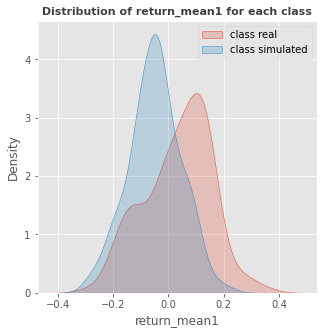

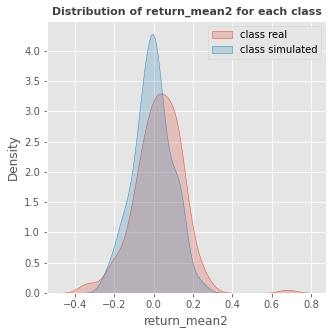

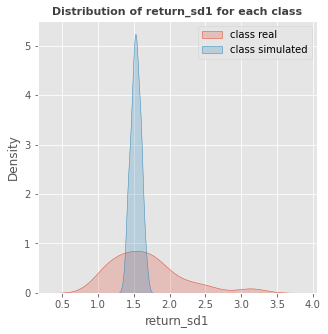

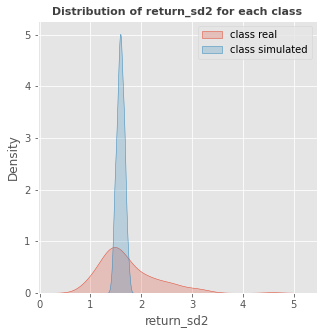

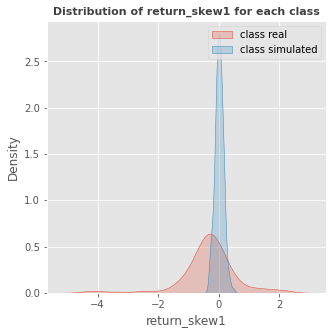

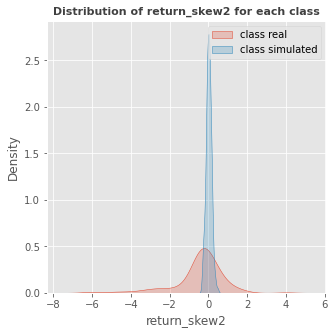

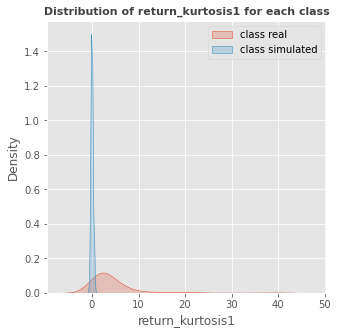

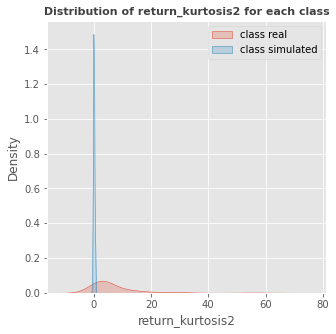

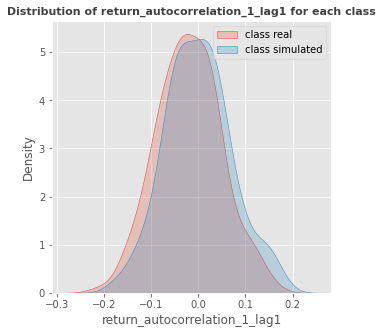

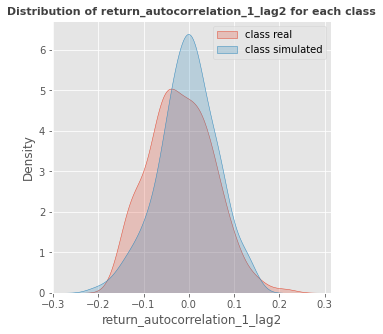

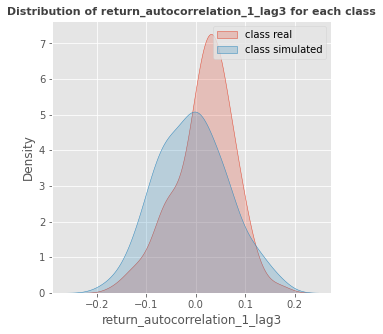

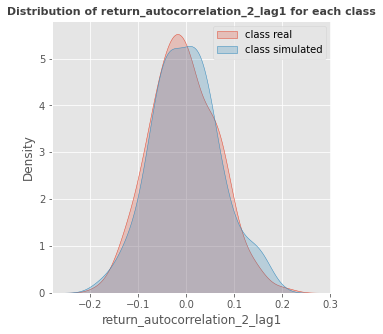

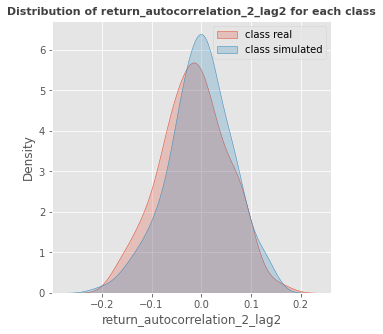

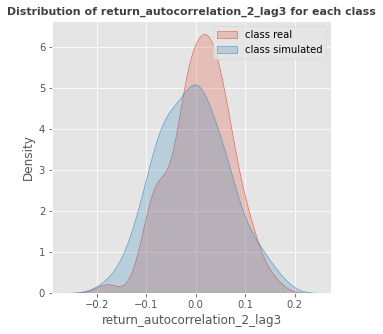

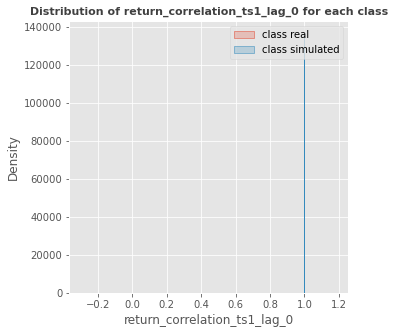

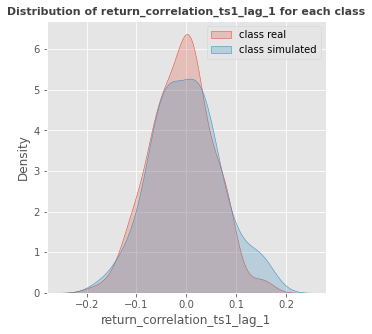

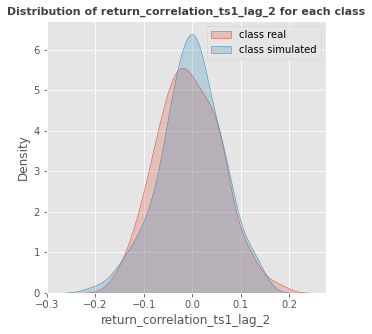

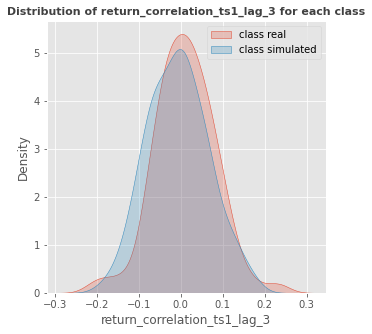

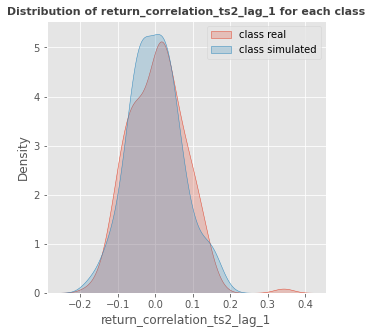

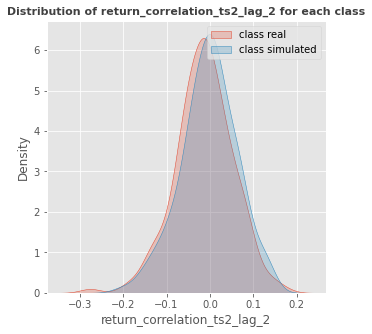

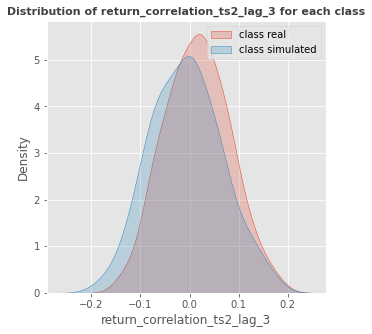

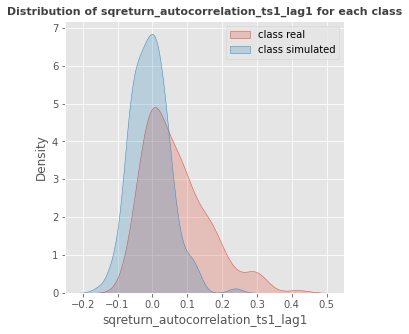

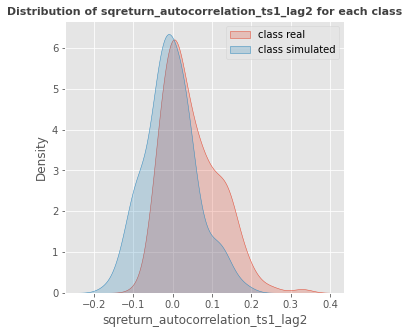

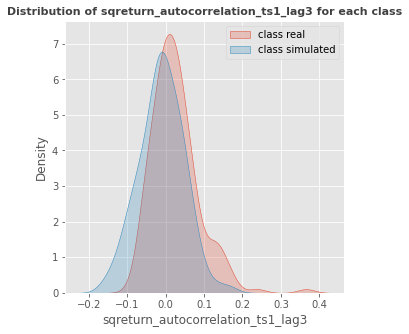

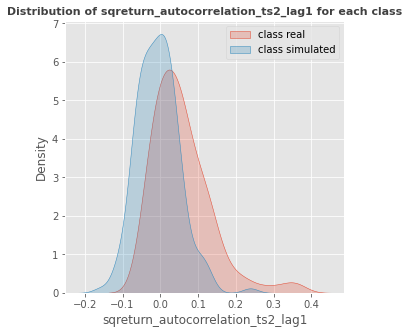

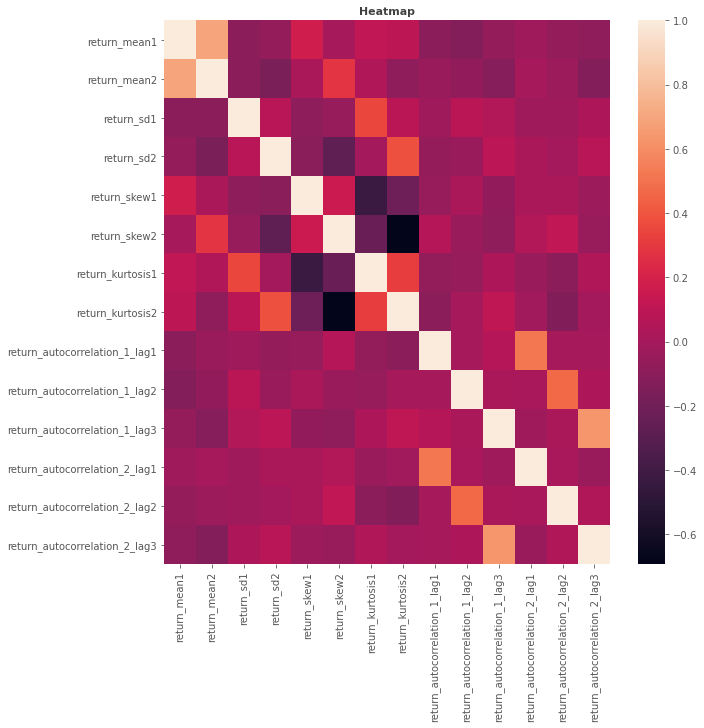

In [6]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])

    n_sim_ou_log_prices = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=mu11, mu12=params[0], 
        mu21=mu21, mu22=params[1],
        sigma11=params[2], sigma12=params[3], 
        sigma21=params[4], sigma22=params[5],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)    
    
    n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
    n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)
    
    n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")
    n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv")


    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")

    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")


In [7]:
print(results)
print(accuracy_average)
print(accuracy_std)

[1.0, 0.9865771812080537, 0.9932885906040269, 1.0, 1.0]
0.9959731543624162
0.005369127516778515
